In [47]:
from opr_structs import *
from opr_logic import *
from pprint import pprint
import copy
import itertools

In [48]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")
logger.setLevel(logging.WARNING)

from contextlib import contextmanager

@contextmanager
def loggingcm(level=logging.DEBUG):
    # Code to acquire resource, e.g.:
    logger.setLevel(level)
    try:
        yield
    finally:
        # Code to release resource, e.g.:
        logger.setLevel(logging.WARNING)

with loggingcm():
    logger.debug("debug1")
logger.debug("debug2")

DEBUG:root:test
DEBUG:root:debug1


In [49]:
from units import *
from opr_ai import *

In [50]:
import matplotlib.pyplot as plt

def plot_items(ax, items, name_func):
    y = []
    x = []
    names = []
    for i in items:
        x.append(i.x)
        y.append(i.y)
        name = name_func(i) #f"{u.name} ({len(u.models)}/{u.starting_models})"
        names.append(name)
    
    ax.scatter(x, y)
    for i, n in enumerate(names):
        ax.annotate(n, (x[i], y[i]))

def plot_battle(battle, cursor_x=0, cursor_y=0):
    fig = plt.figure(figsize=(10,8))
    ax = fig.subplots()
    for p in battle.players:
        plot_items(ax, [u for u in p.units if u.alive], lambda u: f"{u.name} ({len(u.models)}/{u.starting_models})")
    
    plot_items(ax, battle.objectives, lambda o: f"{o.controller}")
    
    ax.scatter(cursor_x, cursor_y, c="red")
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 48])
    
    
    plt.gca().set_aspect('equal')
    

    plt.show()

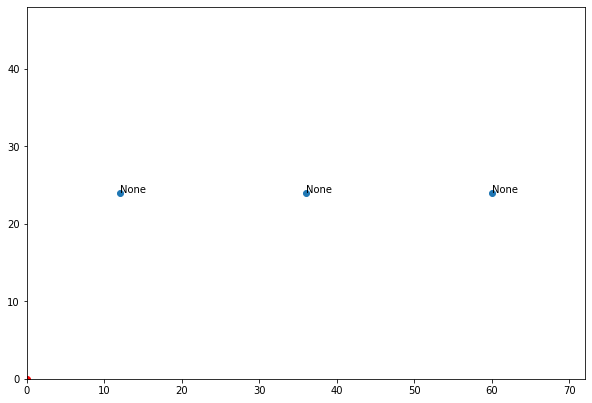

In [51]:
plot_battle(Battle([]))

In [70]:
import tqdm
def mc(func, times=10000):
    results = []
    for i in tqdm.tqdm(range(times)):
        results.append(func())
        
    print([(k, len(list(g))) for k, g in itertools.groupby(sorted(results))])
    
    return sum(results) / len(results)

In [71]:
def eval_options(options, eval_func, *args):
    best = options[0]
    best_val = eval_func(options[0], *args)
    for option in options[1:]:
        val = eval_func(option, *args)
        if val > best_val:
            best = option
            best_val = val
    return best

In [198]:
def activate_score(unit, battle):
    total = 0
#     if "Wavering" in unit.rules:
#         total += 1
    if "Fatigued" not in unit.rules and "Impact" in unit.models[-1].rules:
        total += 1
#     if len(unit.models) > 10:
#         total += 2
    return total

In [199]:
def a_choose_unit_to_activate(battle, player):
    available_units = [u for u in player.units if "Activated" not in u.rules and u.alive]
    if not available_units:
        return None
    
    return eval_options(available_units, activate_score, battle)
    
    # pick a non-fatigued impact unit first
#     nfi = [u for u in available_units if "Fatigued" not in u.rules and "Impact" in u.models[-1].rules]
#     if nfi:
#         return random.sample(nfi, 1)[0]
    
    # TODO sample from a zone, with priority baseed on rules
    # for now, just sample a random unit
    return random.sample(available_units, 1)[0]

In [200]:
def enemies_in_way(battle, unit, target):
    # hybrid method: get the enemy units that are within the square that has corners that are the unit and the objective,
    # plus the units that are close to the objective
    units = battle.all_units
    in_way = []
    dist_to_target = calc_distance(*unpack_points(unit, target))
    for u in units:
        to_target = calc_distance(*unpack_points(u, target))
        to_unit = calc_distance(*unpack_points(u, unit))
        from_line = line_point_distance(unit, target, u)
        
        # if it's close enough to the target add it even if it's not on the line
        if to_target > 3.5:
            if to_unit > dist_to_target or to_target > dist_to_target:
                continue
            if from_line > 6:
                continue
        if u.controller == unit.controller:
            continue
        in_way.append(u)
        
    return in_way

In [201]:
def a_choose_action_for_unit(battle, player, unit):
    # if unit is wavering/shaken, they can only hold
    if "Wavering" in unit.rules:
        return ("Hold",)
    speed = unit.speed
    
    # TODO decision tree for unit types, for now move towards nearest enemy unit
    enemy_units = [u for u in battle.all_units if u.controller != player.name and u.alive]
    
    if not enemy_units:
        not_controlled = [o for o in battle.objectives if o.controller != player.name]
        
        if not not_controlled:
            return "Hold", None
        
        closest_obj = get_closest(unit.x, unit.y, not_controlled)
        distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
        return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
    
    closest = get_closest(unit.x, unit.y, enemy_units)
    distance_to_closest = calc_distance(unit.x, unit.y, closest.x, closest.y)
    
    # now that we have the closest, figure out the angle to them. 
    angle = get_angle_to(unit.x, unit.y, closest)
    
    not_controlled = [o for o in battle.objectives if o.controller != player.name]
    
    # melee decision tree
    if unit.is_melee:
        # step 1
        if not_controlled:
            closest_obj = get_closest(unit.x, unit.y, not_controlled)
            distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
#             in_way = [u for u in units_in_way(battle, unit, closest_obj) if u.controller != player.name and u.alive and calc_distance(u.x, u.y, closest_obj.x, closest_obj.y) < (distance_to + 3.5)]
            # step 2
            in_way = enemies_in_way(battle, unit, closest_obj)
            if in_way:
                closest_in_way = get_closest(unit.x, unit.y, in_way)
                if calc_distance(*unpack_points(unit, closest_in_way)) <= speed * 2:
                    return "Charge", closest_in_way
            return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
        else: # 3
            # 3 yes
            if distance_to_closest <= speed * 2:
                return "Charge", closest
            # 3 no
            return "Rush", speed * 2, angle
    
    elif unit.is_ranged:
#         u_range = unit.range
#         if unit.range > distance_to_closest:
#             return "Advance", 0, 0, closest
        shootable_distance = speed + unit.range
        in_range = [u for u in enemy_units if calc_distance(unit.x, unit.y, u.x, u.y) <= shootable_distance]
        log.debug(f"{in_range}")
        if in_range:
            target = random.choice(in_range)
            for u in in_range:
                if "Wavering" in unit.rules:
                    continue
                
                dist_to_morale = len(u.models) - u.starting_models / 2
                target_to_morale = len(target.models) - target.starting_models / 2
                if dist_to_morale < target_to_morale:
                    log.debug(f"switching target to {u}, {dist_to_morale} {target_to_morale}")
                    target = u
        else:
            target = closest
        
        angle = get_angle_to(unit.x, unit.y, target)
        distance_to_target = calc_distance(unit.x, unit.y, target.x, target.y)
        
        dist_to_move = max(0, min(distance_to_target - 3, speed))
        
        log.debug(f"unit {unit}, angle {angle}, distance {dist_to_move} {distance_to_target}, target {target}")
        
        return "Advance", dist_to_move, angle, target
    
    if not unit.is_melee:
        # hybrid decision tree
        
        if distance_to_closest <= speed * 2:
            return "Charge", closest
        
        dist_to_move = max(0, min(distance_to_closest - 2, speed))
        
        return "Advance", dist_to_move, angle, closest
    
    if distance_to_closest <= speed * 2:
        return "Charge", closest
    
    return "Rush", speed * 2, angle




In [202]:
def a_choose_action_for_unit(battle, player, unit):
    """ old activation"""
    # if unit is wavering/shaken, they can only hold
    if "Wavering" in unit.rules:
        return ("Hold",)
    speed = unit.speed
    
    # TODO decision tree for unit types, for now move towards nearest enemy unit
    enemy_units = [u for u in battle.all_units if u.controller != player.name and u.alive]
    
    if not enemy_units:
        not_controlled = [o for o in battle.objectives if o.controller != player.name]
        
        if not not_controlled:
            return "Hold", None
        
        closest_obj = get_closest(unit.x, unit.y, not_controlled)
        distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
        return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
    
    closest = get_closest(unit.x, unit.y, enemy_units)
    distance_to_closest = calc_distance(unit.x, unit.y, closest.x, closest.y)
    
    # now that we have the closest, figure out the angle to them. 
    angle = get_angle_to(unit.x, unit.y, closest)
    
    
    # melee decision tree
    if unit.is_melee:
        not_controlled = [o for o in battle.objectives if o.controller != player.name]
        if not_controlled:
            closest_obj = get_closest(unit.x, unit.y, not_controlled)
            distance_to = calc_distance(unit.x, unit.y, closest_obj.x, closest_obj.y)
            in_way = [u for u in units_in_way(battle, unit, closest_obj) if u.controller != player.name and u.alive and calc_distance(u.x, u.y, closest_obj.x, closest_obj.y) < (distance_to + 3.5)]
#             in_way = enemies_in_way(battle, unit, closest_obj)
            if in_way:
                closest_in_way = get_closest(unit.x, unit.y, in_way)
                if calc_distance(*unpack_points(unit, closest_in_way)) <= speed * 2:
                    return "Charge", closest_in_way
            return "Rush", min(speed * 2, distance_to + 2.5), get_angle_to(unit.x, unit.y, closest_obj)
        else: # 3
            if distance_to_closest <= speed * 2:
                return "Charge", closest
            return "Rush", speed * 2, angle

    elif unit.is_ranged:
#         u_range = unit.range
#         if unit.range > distance_to_closest:
#             return "Advance", 0, 0, closest
        shootable_distance = speed + unit.range
        in_range = [u for u in enemy_units if calc_distance(unit.x, unit.y, u.x, u.y) <= shootable_distance]
        if in_range:
            target = random.choice(in_range)
            
            # target prio
#             for u in in_range:
#                 if "Wavering" in unit.rules:
#                     continue
                
#                 dist_to_morale = len(u.models) - u.starting_models / 2
#                 target_to_morale = len(target.models) - target.starting_models / 2
#                 if dist_to_morale < target_to_morale:
#                     log.debug(f"switching target to {u}, {dist_to_morale} {target_to_morale}")
#                     target = u
            
        else:
            target = closest
        
        angle = get_angle_to(unit.x, unit.y, target)
        distance_to_target = calc_distance(unit.x, unit.y, target.x, target.y)
        
        dist_to_move = max(0, min(distance_to_target - 3, speed))
        
        return "Advance", dist_to_move, angle, closest
    
    if not unit.is_melee:
        
        dist_to_move = max(0, min(distance_to_closest - 2, speed))
        
        return "Advance", dist_to_move, angle, closest
    
    if distance_to_closest <= speed * 2:
        return "Charge", closest
    
    return "Rush", speed * 2, angle

In [203]:
def advanced_activation(battle, player):
    unit = a_choose_unit_to_activate(battle, player)
    log.debug(f"aa {unit}")
    if unit is None:
        log.debug(f"skipping {player}")
        return (None, None)

    action = a_choose_action_for_unit(battle, player, unit)
    return (unit, action)

In [233]:
import random
def nvn_full(a, b, draw_value=0.5):
    random.shuffle(a)
    random.shuffle(b)
    # start units at 12x12 and increment by 6 for each
    # spread units along the front
    center = 36
    edge = 6
#     spacing = (2 * center) / (len(a))
#     for i, u in enumerate(a):
#         u.y = 11.5
#         u.x = random.randint(6, 6*12-1)
    
#     spacing = (2 * center) / (len(b))
#     for i, u in enumerate(b):
#         u.y = 36.5
#         u.x = 6 + i * spacing

    
        
    p1 = Player("p1", a, (0, 12, 0, 72))
    p2 = Player("p2", b, (36, 48, 0, 72))
    
#     p1.activation = advanced_activation
    p1.activation = basic_activation
    p2.activation = basic_activation
    
    battle = Battle([p1, p2])
#     obj_x = 6 + (len(a) - 1) * 3
#     battle.objectives = [Objective(36, 24),]
#     check_objectives(battle)

    deploy(battle)
    
    def on_line(units, y):
        for i, u in enumerate(units):
            u.y = y
            u.x = random.randint(6, 6*12-1)
            
    on_line(p1.units, 11.5 - 6)
    on_line(p2.units, 36.5 + 6)
    
#     spacing = (2 * center) / (len(p2.units))
#     for i, u in enumerate(p2.units):
#         u.y = 36.5 + 10
#         u.x = random.randint(6, 6*12-1)
    
#     run_battle(battle)
    if logger.getEffectiveLevel() <= 10:
        plot_battle(battle)
    next_player = 0
    for i in range(4):
        next_player = do_round(battle, next_player)
        if logger.getEffectiveLevel() <= 10:
            plot_battle(battle)
            print("Units:")
            pprint(battle.all_units)
            pprint(battle.objectives)
    
    p1_score = sum([1 for o in battle.objectives if o.controller == p1.name])
    p2_score = sum([1 for o in battle.objectives if o.controller == p2.name])
    
        
    if p1_score == p2_score:
        return 0.5
    elif p1_score > p2_score:
        return 1
    else:
        return 0

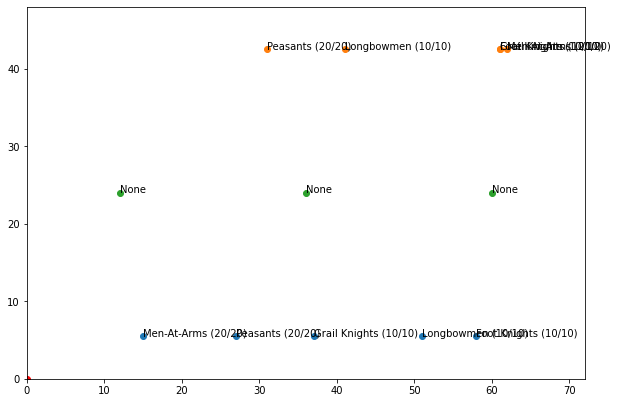

DEBUG:opr_logic:Starting Round 1
DEBUG:opr_logic:executing p1 Unit(Grail Knights (10/10)(37.0,5.5), ('Rush', 16, 3.087591153213825)
DEBUG:opr_logic:executing p2 Unit(Grail Knights (10/10)(61.0,42.5), ('Rush', 16, 0.05400150037596829)
DEBUG:opr_logic:executing p1 Unit(Men-At-Arms (20/20)(15.0,5.5), ('Rush', 12, 2.9808299129639586)
DEBUG:opr_logic:executing p2 Unit(Peasants (20/20)(31.0,42.5), ('Advance', 6, -0.23962466521863265, Unit(Grail Knights a(10/10)(36.1,21.5))
DEBUG:opr_logic:Unit(Peasants a(20/20)(32.4,36.7) shooting at Unit(Grail Knights a(10/10)(36.1,21.5)
DEBUG:opr_logic:Out of range
DEBUG:opr_logic:executing p1 Unit(Foot Knights (10/10)(58.0,5.5), ('Rush', 12, -3.0339027827569724)
DEBUG:opr_logic:executing p2 Unit(Longbowmen (10/10)(41.0,42.5), ('Advance', 6, -0.6302923890262576, Unit(Grail Knights a(10/10)(36.1,21.5))
DEBUG:opr_logic:Unit(Longbowmen a(10/10)(44.5,37.7) shooting at Unit(Grail Knights a(10/10)(36.1,21.5)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:5 hits
DEBU

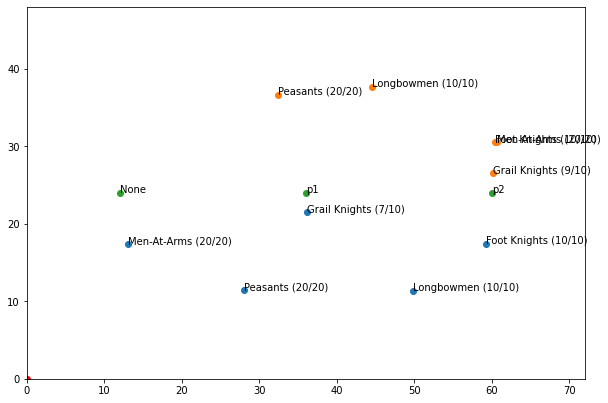

DEBUG:opr_logic:Starting Round 2
DEBUG:opr_logic:executing p1 Unit(Grail Knights (7/10)(36.1,21.5), ('Rush', 16, -1.6761442836010267)
DEBUG:opr_logic:executing p2 Unit(Grail Knights (9/10)(60.1,26.5), ('Charge', Unit(Grail Knights a(7/10)(52.0,23.2))
DEBUG:opr_logic:Unit(Grail Knights a(9/10)(53.9,23.9) strikes Unit(Grail Knights a(7/10)(52.0,23.2)
DEBUG:opr_logic:num impact: 9
DEBUG:opr_logic:18 attacks
DEBUG:opr_logic:9 hits
DEBUG:opr_logic:5 wounds
DEBUG:opr_logic:Unit(Grail Knights a(2/10)(52.0,23.2) strikes Unit(Grail Knights fa(9/10)(53.9,23.9)
DEBUG:opr_logic:2 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:scores: a: 6, d: 1
DEBUG:opr_structs:Grail Knights doing morale test
DEBUG:opr_structs:rolling fearless test
DEBUG:opr_structs:Grail Knights is fearless!
DEBUG:opr_logic:executing p1 Unit(Men-At-Arms (20/20)(13.1,17.3), ('Rush', 9.241664813991312, 2.980829912963958)
DEBUG:opr_logic:executing p2 Unit(Men-At-Arms (20/20)(60.7,30.6), ('Charge', Unit(Grai

Units:
[Unit(Longbowmen a(10/10)(49.8,11.4),
 Unit(Men-At-Arms a(20/20)(13.1,17.3),
 Unit(Foot Knights a(10/10)(59.3,17.4),
 Unit(Grail Knights a(7/10)(36.1,21.5),
 Unit(Peasants a(20/20)(28.0,11.4),
 Unit(Grail Knights a(9/10)(60.1,26.5),
 Unit(Peasants a(20/20)(32.4,36.7),
 Unit(Foot Knights a(10/10)(60.4,30.5),
 Unit(Longbowmen a(10/10)(44.5,37.7),
 Unit(Men-At-Arms a(20/20)(60.7,30.6)]
[Objective(12, 24, None), Objective(36, 24, p1), Objective(60, 24, p2)]


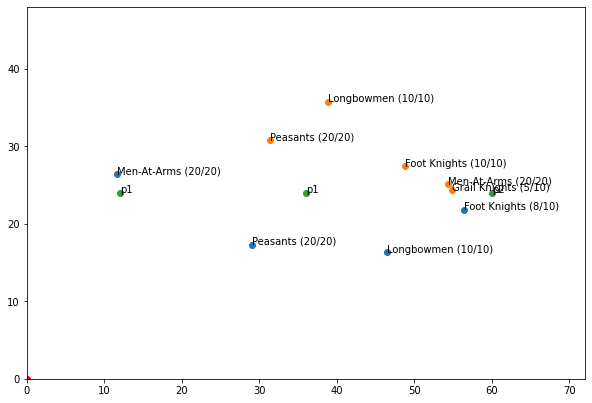

DEBUG:opr_logic:Starting Round 3
DEBUG:opr_logic:executing p1 Unit(Peasants (20/20)(29.1,17.3), ('Advance', 6, -2.969311267767459, Unit(Peasants (20/20)(31.4,30.8))
DEBUG:opr_logic:Unit(Peasants a(20/20)(30.1,23.2) shooting at Unit(Peasants (20/20)(31.4,30.8)
DEBUG:opr_logic:20 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_logic:executing p2 Unit(Grail Knights s(5/10)(54.8,24.3), ('Hold',)
DEBUG:opr_logic:executing p1 Unit(Men-At-Arms (20/20)(11.6,26.5), ('Rush', 12, -1.5198537745488419)
DEBUG:opr_logic:executing p2 Unit(Men-At-Arms (20/20)(54.3,25.1), ('Charge', Unit(Foot Knights (8/10)(56.5,21.8))
DEBUG:opr_logic:Unit(Men-At-Arms a(20/20)(55.4,23.5) strikes Unit(Foot Knights (8/10)(56.5,21.8)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:3 hits
DEBUG:opr_logic:2 wounds
DEBUG:opr_logic:Unit(Foot Knights (6/10)(56.5,21.8) strikes Unit(Men-At-Arms fa(20/20)(55.4,23.5)
DEBUG:opr_logic:6 attacks
DEBUG:opr_logic:3 hits
DEBUG:opr_logic:3 wounds
DEBUG:opr_logic:scores: a: 5,

Units:
[Unit(Longbowmen a(10/10)(46.4,16.3),
 Unit(Men-At-Arms a(20/20)(11.6,26.5),
 Unit(Foot Knights fa(8/10)(56.5,21.8),
 Unit(Grail Knights fa(0/10)(52.0,23.2),
 Unit(Peasants a(20/20)(29.1,17.3),
 Unit(Grail Knights fsa(5/10)(54.8,24.3),
 Unit(Peasants a(20/20)(31.4,30.8),
 Unit(Foot Knights a(10/10)(48.8,27.4),
 Unit(Longbowmen a(10/10)(38.9,35.7),
 Unit(Men-At-Arms fa(20/20)(54.3,25.1)]
[Objective(12, 24, p1), Objective(36, 24, p1), Objective(60, 24, p2)]


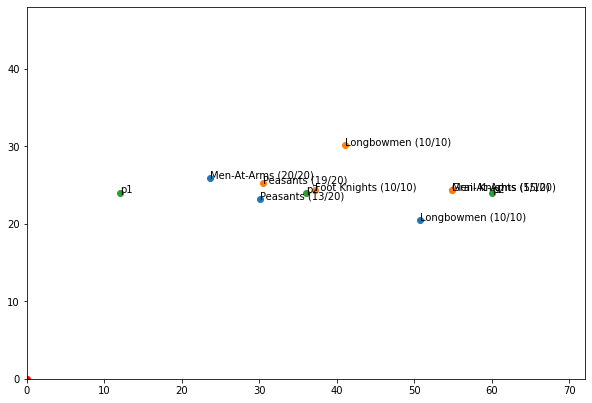

DEBUG:opr_logic:Starting Round 4
DEBUG:opr_logic:executing p1 Unit(Longbowmen (10/10)(50.8,20.5), ('Advance', 6, 1.8469688349603754, Unit(Grail Knights (5/10)(54.8,24.3))
DEBUG:opr_logic:Unit(Longbowmen a(10/10)(45.0,22.1) shooting at Unit(Grail Knights (5/10)(54.8,24.3)
DEBUG:opr_logic:10 attacks
DEBUG:opr_logic:2 hits
DEBUG:opr_logic:1 wounds
DEBUG:opr_structs:Grail Knights doing ranged morale test
DEBUG:opr_logic:executing p2 Unit(Grail Knights (4/10)(54.8,24.3), ('Charge', Unit(Longbowmen a(10/10)(45.0,22.1))
DEBUG:opr_logic:Unit(Grail Knights a(4/10)(46.9,22.5) strikes Unit(Longbowmen a(10/10)(45.0,22.1)
DEBUG:opr_logic:num impact: 4
DEBUG:opr_logic:8 attacks
DEBUG:opr_logic:5 hits
DEBUG:opr_logic:4 wounds
DEBUG:opr_logic:Unit(Longbowmen a(6/10)(45.0,22.1) strikes Unit(Grail Knights fa(4/10)(46.9,22.5)
DEBUG:opr_logic:6 attacks
DEBUG:opr_logic:1 hits
DEBUG:opr_logic:0 wounds
DEBUG:opr_logic:scores: a: 4, d: 1
DEBUG:opr_structs:Longbowmen doing morale test
DEBUG:opr_structs:Longbow

Units:
[Unit(Longbowmen a(10/10)(50.8,20.5),
 Unit(Men-At-Arms a(20/20)(23.6,25.9),
 Unit(Foot Knights fa(0/10)(56.5,21.8),
 Unit(Grail Knights (0/10)(52.0,23.2),
 Unit(Peasants a(13/20)(30.1,23.2),
 Unit(Grail Knights a(5/10)(54.8,24.3),
 Unit(Peasants a(19/20)(30.4,25.2),
 Unit(Foot Knights a(10/10)(37.2,24.3),
 Unit(Longbowmen a(10/10)(41.0,30.1),
 Unit(Men-At-Arms fa(15/20)(54.8,24.3)]
[Objective(12, 24, p1), Objective(36, 24, p2), Objective(60, 24, p2)]


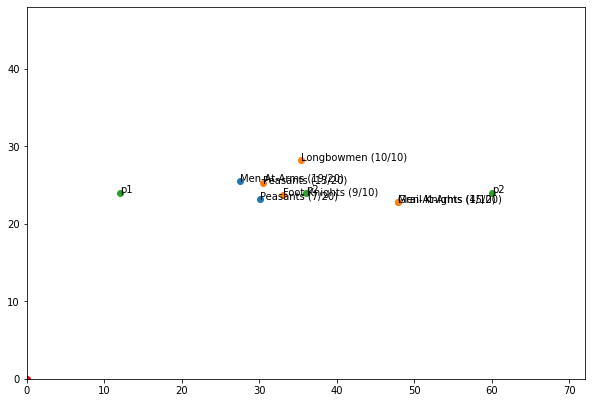

Units:
[Unit(Longbowmen fsa(0/10)(45.0,22.1),
 Unit(Men-At-Arms fa(19/20)(27.4,25.5),
 Unit(Foot Knights (0/10)(56.5,21.8),
 Unit(Grail Knights (0/10)(52.0,23.2),
 Unit(Peasants fa(7/20)(30.1,23.2),
 Unit(Grail Knights fa(4/10)(47.9,22.8),
 Unit(Peasants fa(13/20)(30.4,25.2),
 Unit(Foot Knights fa(9/10)(33.1,23.7),
 Unit(Longbowmen a(10/10)(35.4,28.2),
 Unit(Men-At-Arms fa(15/20)(47.9,22.8)]
[Objective(12, 24, p1), Objective(36, 24, p2), Objective(60, 24, p2)]
0


In [234]:
a = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
# a = [men_at_arms,]
b = [men_at_arms,longbowmen_10,peasants,grail_knights_c,foot_knights,]
with loggingcm(): print(nvn_full(copify(a), copify(b)))

In [235]:
a_first = mc(lambda: nvn_full(copify(a), copify(b)), times=10000)
b_first = 1 - mc(lambda: nvn_full(copify(b), copify(a)), times=10000)
(a_first + b_first) / 2, a_first, b_first

100%|████████████████████████████████████| 10000/10000 [00:46<00:00, 216.21it/s]


[(0, 3345), (0.5, 2376), (1, 4279)]


100%|████████████████████████████████████| 10000/10000 [00:46<00:00, 215.69it/s]

[(0, 3331), (0.5, 2315), (1, 4354)]


(0.49777499999999997, 0.5467, 0.44884999999999997)

In [229]:
p = 0.5
n = 10000
1.96 * math.sqrt((p * (1-p)) / n)

0.0098

base: (0.49695, 0.2868, 0.7071000000000001)
ranged targeting smaller units: (0.50455, 0.20405, 0.80505)
ranged skipping already wavering units: (0.49735, 0.19645, 0.79825)

new base: (0.5025, 0.5324, 0.4726) | (0, 3545), (0.5, 2262), (1, 4193) | (0, 3595), (0.5, 2262), (1, 4143) - very balanced for both starting
current: (0.49665, 0.36085, 0.63245) | (0, 5307), (0.5, 2169), (1, 2524) | (0, 5212), (0.5, 2225), (1, 2563) - new logic seems to hurt when starting?

reset to old: (0.500075, 0.5289, 0.47125) | (0, 3557), (0.5, 2308), (1, 4135) | (0, 3554), (0.5, 2317), (1, 4129) - matches base
No impact priority: (0.496875, 0.4933, 0.50045) | (0, 3920), (0.5, 2294), (1, 3786) | (0, 3879), (0.5, 2251), (1, 3870) - hurts a bit. 
eval_options: (0.503675, 0.49825, 0.5091) | (0, 3854), (0.5, 2327), (1, 3819) | (0, 3937), (0.5, 2308), (1, 3755) - slightly worse when striking first, but better than when striking last. 
eval no mass bonus: (0.5028, 0.52335, 0.48225) | (0, 3636), (0.5, 2261), (1, 4103) | (0, 3672), (0.5, 2301), (1, 4027) - that might have been the issue
ranged/melee changes: (0.497375, 0.3713, 0.62345) - way worse when starting first
melee in_way: (0.50565, 0.39625, 0.61505) | this in_way does way worse when starting first
ranged prio: (0.4968, 0.5082, 0.48540000000000005) - still worse, which is interesting
random_selection: (0.505125, 0.49845, 0.5118) - moving first is somehow worse
wavering_first: (0.5017, 0.49235, 0.51105) - somehow a little bit worse
impact_first: (0.5004, 0.52855, 0.47224999999999995)

base: (0.497825, 0.52705, 0.4686) - going first has slight advantage
random placement vs random on line placement: (0.501325, 0.40285, 0.5998) - on line wins if going second
random placement vs random 6"back placement: (0.502775, 0.56685, 0.4387) - back wins if going first
random placement vs random 10"back placement: (0.4989, 0.6289, 0.3689) - back wins if going first

on_line vs on_line: (0.50385, 0.42125, 0.58645) - on line wins if going second
on_line vs 6": (0.4991, 0.6696, 0.3286) - back wins when going second
6" vs 6": (0.49777499999999997, 0.5467, 0.44884999999999997) - going first wins

In [146]:
0.5289 - 0.49825

0.03065000000000001